In [1]:
import datetime
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.feature_selection import SelectKBest, chi2, f_classif

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 42
GOOD_CNTR_CLR = '#5FFF92'
BAD_CNTR_CLR = '#FF665F'

In [2]:
# Загрузка общей выборки
data = pd.read_csv('../data/3/tula_yarobl_finished.csv', converters={'okpd': str})
data = data.dropna()
print('Размер выборки (строки, столбцы): {}'.format(data.shape))
data.head(5)

Размер выборки (строки, столбцы): (42412, 39)


,cntrID,ter_good_cntr_share,sup_cntr_num,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,...,okpd,price,pmp,cntr_lvl,sign_date,exec_date,purch_type,price_higher_pmp,price_too_low,cntr_result
0,1505511,0.958,10,0.80,0.0,0.2,0.8,314948,0.0,1.0,...,0,634088.54,899416.26,3,20150112,20150630,3,0,0,0
1,1505700,0.958,1,0.00,0.0,1.0,0.0,20962,0.0,1.0,...,0,20962.00,22000.00,2,20150112,20150630,4,0,0,0
2,1506010,0.958,5,0.60,0.0,1.0,0.0,112320,0.0,1.0,...,0,102600.00,114000.00,2,20150101,20160331,4,0,0,0
3,1506012,0.958,5,0.60,0.0,1.0,0.0,112320,0.0,1.0,...,0,438000.00,500000.00,2,20150112,20160331,4,0,0,0
4,1506028,0.958,4,0.75,0.0,1.0,0.0,123842,0.0,1.0,...,0,107000.00,158511.70,2,20150112,20151231,3,0,0,0


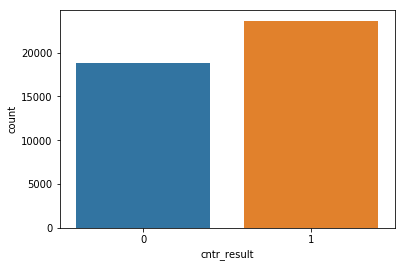

In [3]:
sb.countplot(x='cntr_result', data=data)

In [4]:
bad_cntr = data.loc[data.cntr_result == 0]
good_cntr = data.loc[data.cntr_result == 1].sample(bad_cntr.shape[0], random_state=RANDOM_SEED)
data = bad_cntr.append(good_cntr)
print('Размер выборки после балансирования (строки, столбцы): {}'.format(data.shape))

Размер выборки после балансирования (строки, столбцы): (37546, 39)


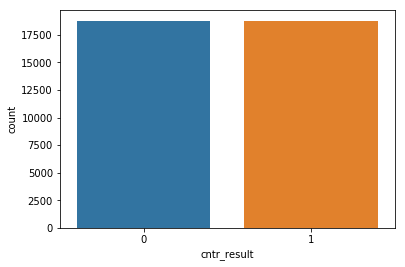

In [5]:
sb.countplot(x='cntr_result', data=data)

In [6]:
# Удаление контрактов, у которых не указана дата окончания
data.drop(data[data.exec_date == -1].index, inplace=True)
data.drop(data[data.sup_cntr_avg_price == 0].index, inplace=True)

### Описание переменных

#### Территория 
1. ter_good_cntr_share - доля хороших контрактов для территории заказчика

#### Заказчик
2. sup_cntr_num - количество завершенных контрактов
3. sup_good_cntr_share - доля хороших контрактов
4. sup_fed_cntr_share - доля контрактов федерального уровня
5. sup_sub_cntr_share - доля контрактов уровня субъекта РФ
6. sup_nun_cntr_share - доля контрактов муниципального уровня
7. sup_cntr_avg_price - средняя цена контрактов
8. sup_cntr_avg_penalty - средняя доля пени от цены контрактов
9. sup_no_pnl_share - доля контрактов без штрафов
10. sup_1s_sev - доля контрактов поставщика с его односторонним разрывом
11. sup_1s_org_sev - доля контрактов поставщика с односторонним разрывом со стороны заказчика
12. sup_okpd_exp - доля контрактов с OKPD2, совпадающим с OKPD2 текущего контракта
13. sup_sim_price - доля контрактов с ценой, отличающейся от цены текущего контракта на менее 20%
14. sup_status - статус поставщика (из таблицы fx_OOS_StatusSup)
15. sup_type - тип поставщика (из таблицы fx_OOS_PartType)

#### Поставщик
16. org_cntr_num - количество завершенных контрактов у заказчика
17. org_good_cntr_share - доля хороших контрактов
18. org_fed_cntr_share - доля контрактов федерального уровня
19. org_sub_cntr_share - доля контрактов уровня субъекта РФ
20. org_nun_cntr_share - доля контрактов муниципального уровня
21. org_cntr_avg_price - средняя цена контрактов заказчика
22. org_1s_sev - доля контрактов у заказчика с его односторонним разрывом
23. org_1s_sup_sev - доля контрактов у заказчика с односторонним разрывом со стороны поставщика
24. org_sim_price_share - доля контрактов с ценой, отличающейся от цены текущего контракта на менее 20%
25. cntr_num_together - количество завершенных контрактов с поставщиком, исполняющим данный контракт
26. org_form - форма организации заказчика (из таблицы fx_OOS_OrgForm)
27. org_type - тип организации заказчика (из таблицы d_oos_TypeOrg)

#### ОКПД
28. okpd_good_cntr_share - доля хороших контрактов для данного ОКПД

#### Контракт
29. okpd - ОКПД2 контракта
30. price - цена контракта
31. pmp - НМЦК контракта
32. cntr_lvl - уровень контракта (федеральный, муниципальный, субъекта РФ)
33. sign_date - дата начала контракта
34. exec_date - дата окончания исполнения контракта
35. purch_type - тип закупки
36. price_higher_pmp - 1, если цена больше МНЦК, 0 - иначе
37. price_too_low - 1, если цена меньше МНЦК на более 40%, 0 - иначе
38. cntr_result - результат контракта (0 - плохой контракт, 1 - хороший)

In [7]:
# количественные переменнные
num_var = [
    'sup_cntr_num', 'sup_cntr_avg_price', 
    'org_cntr_num', 'org_cntr_avg_price',
    'price', 'pmp', 'cntr_num_together'
]

# количественные переменные принимающие значения на отрезке [0, 1]
num_var01 = [
    'ter_good_cntr_share', 'sup_good_cntr_share', 'sup_fed_cntr_share', 'sup_sub_cntr_share', 'sup_nun_cntr_share',
    'sup_cntr_avg_penalty', 'sup_1s_sev', 'sup_1s_org_sev', 'sup_okpd_exp', 'sup_no_pnl_share', 
    'sup_sim_price_share', 'org_good_cntr_share', 'org_fed_cntr_share', 'org_sub_cntr_share', 'org_nun_cntr_share',
    'org_1s_sev', 'org_1s_sup_sev', 'org_sim_price_share', 'okpd_good_cntr_share'
]

# категориальные небинарные переменные
cat_var = [
    
    'sup_status', 'sup_type', 'org_form', 'org_type',
    'okpd', 'cntr_lvl', 'purch_type', 
]

# категориальные бинарные переменные
cat_bin_var = [
    'price_higher_pmp', 'price_too_low'
]

### Анализ количественных переменных

In [8]:
# Описательные статистики (среднее, стадартное отклонение, квартили)
data[num_var].describe()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,price,pmp,cntr_num_together
count,37543.000000,3.754300e+04,37543.000000,3.754300e+04,3.754300e+04,3.754300e+04,37543.000000
mean,2392.686786,5.360155e+05,515.267533,6.136472e+05,6.860614e+05,7.442153e+05,24.239938
std,3238.846070,8.879019e+06,704.574383,2.114339e+06,8.956441e+06,9.318945e+06,35.118188
min,1.000000,1.000000e+03,1.000000,2.673000e+03,5.767000e+01,0.000000e+00,1.000000
25%,18.000000,8.772700e+04,116.000000,1.489080e+05,3.910500e+04,4.282015e+04,2.000000
50%,251.000000,1.447320e+05,238.000000,2.459070e+05,1.049055e+05,1.182719e+05,9.000000
75%,6921.000000,2.344480e+05,653.000000,4.097675e+05,3.385122e+05,3.898000e+05,40.000000
max,7651.000000,1.151663e+09,6408.000000,6.803218e+07,1.151663e+09,1.205930e+09,509.000000


In [9]:
# Мода и медиана
for nv in num_var:
    print('{}: {}, {}, {}'.format(nv, int(data[nv].mode()[0]), int(data[nv].median()), int(data[nv].mean())))

sup_cntr_num: 7651, 251, 2392
sup_cntr_avg_price: 144732, 144732, 536015
org_cntr_num: 260, 238, 515
org_cntr_avg_price: 284701, 245907, 613647
price: 4594368, 104905, 686061
pmp: 0, 118271, 744215
cntr_num_together: 1, 9, 24


In [10]:
num_var_cntr = list(num_var) + ['cntr_result']

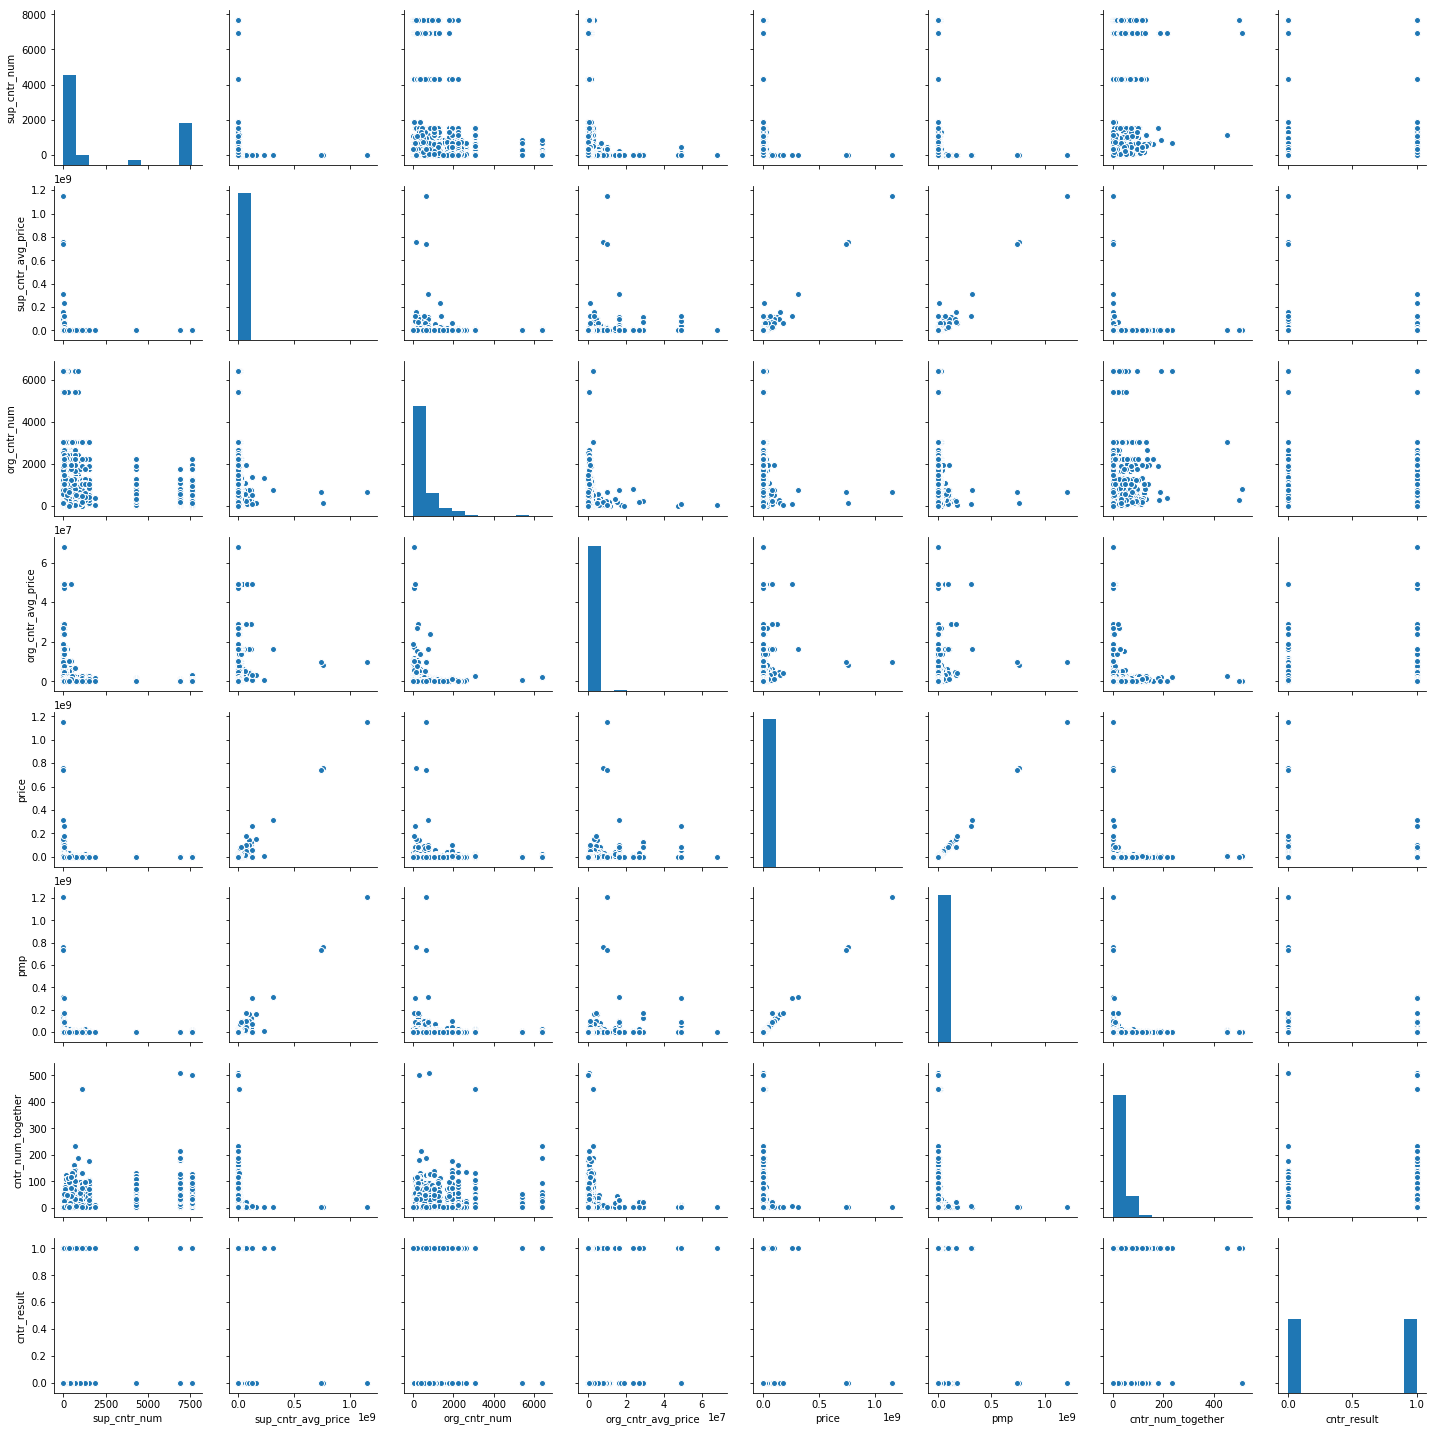

In [11]:
# Гистограммы всех количественных переменных и графики попарных зависимостей
sb.pairplot(data[num_var_cntr])

**Замечание**. Имеет смысл прологарифмировать все количественные переменные, так как они имеют большие правые хвосты.

In [12]:
# Линейная корреляция количественных переменных между собой и с целевой переменной
data[num_var_cntr].corr()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,price,pmp,cntr_num_together,cntr_result
sup_cntr_num,1.000000,-0.032986,-0.254256,-0.121685,-0.013033,-0.014186,0.523290,-0.350229
sup_cntr_avg_price,-0.032986,1.000000,0.013606,0.167620,0.962452,0.958254,-0.020997,-0.003920
org_cntr_num,-0.254256,0.013606,1.000000,0.060269,0.011624,0.012140,0.023336,0.255348
org_cntr_avg_price,-0.121685,0.167620,0.060269,1.000000,0.193840,0.205929,-0.054482,0.058632
price,-0.013033,0.962452,0.011624,0.193840,1.000000,0.997599,-0.014516,-0.012848
pmp,-0.014186,0.958254,0.012140,0.205929,0.997599,1.000000,-0.016236,-0.013183
cntr_num_together,0.523290,-0.020997,0.023336,-0.054482,-0.014516,-0.016236,1.000000,-0.127850
cntr_result,-0.350229,-0.003920,0.255348,0.058632,-0.012848,-0.013183,-0.127850,1.000000


**Выводы**
1. Признаки org_cntr_num и sup_cntr_num являются важными, так как имеют большую корреляцию с результатом.
2. Корреляция между pmp, price и sup_cntr_avg_price очень велика, во время предобработки данных необходимо исключить переменные, сильно коррелирующие друг с другом переменных.

Переменные, которые имеют большую корреляцию с результатом на ОВ, не имеют корреляции с результатом для ВФК.

In [13]:
# Логарифмирование всех количественных переменных для подтягивания правого хвоста
for nv in num_var:
    data.loc[data[nv] < 1, nv] = 1
    data[nv] = np.log(data[nv])

In [14]:
data[num_var].describe()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,price,pmp,cntr_num_together
count,37543.000000,37543.000000,37543.000000,37543.000000,37543.000000,37543.000000,37543.000000
mean,5.352006,11.966484,5.552944,12.499927,11.664827,11.582421,2.129291
std,3.000823,1.035462,1.224015,1.003799,1.695486,2.345778,1.619692
min,0.000000,6.907755,0.000000,7.890957,4.054737,0.000000,0.000000
25%,2.890372,11.381985,4.753590,11.911084,10.574006,10.664764,0.693147
50%,5.525453,11.882639,5.472271,12.412709,11.560816,11.680741,2.197225
75%,8.842316,12.364989,6.481577,12.923345,12.732316,12.873389,3.688879
max,8.942592,20.864473,8.765302,18.035491,20.864473,20.910517,6.232448


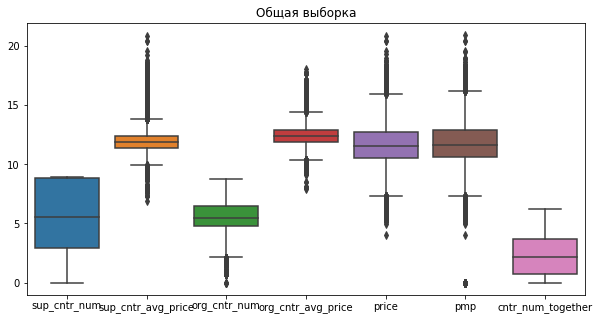

In [15]:
# Ящик с усами (https://datavizcatalogue.com/RU/metody/diagramma_razmaha.html)
# Ящик с усами - визуальная форма представления основных описательных статистик
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
ax.set_title('Общая выборка')
sb.boxplot(data=data[num_var], ax=ax)

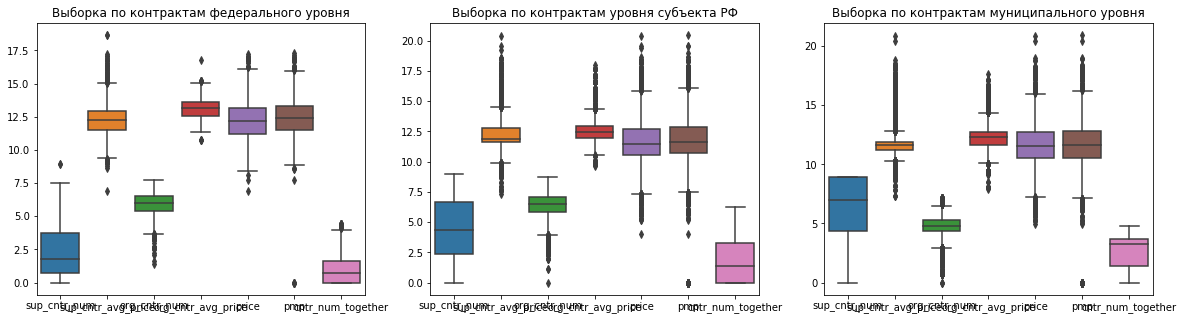

In [16]:
fig = plt.figure(figsize = (20,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('Выборка по контрактам федерального уровня')
ax2.set_title('Выборка по контрактам уровня субъекта РФ')
ax3.set_title('Выборка по контрактам муниципального уровня')

sb.boxplot(data=data.loc[data.cntr_lvl == 1][num_var], ax=ax1)
sb.boxplot(data=data.loc[data.cntr_lvl == 2][num_var], ax=ax2)
sb.boxplot(data=data.loc[data.cntr_lvl == 3][num_var], ax=ax3)

### Анализ количественных переменных с областью значений [0, 1]

In [17]:
# Исправление максимальных значений sup_okpd_exp, которое не может быть больше 1
data.loc[data['sup_okpd_exp'] > 1, 'sup_okpd_exp'] = 1

In [18]:
data[num_var01].describe()

,ter_good_cntr_share,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_cntr_avg_penalty,sup_1s_sev,sup_1s_org_sev,sup_okpd_exp,sup_no_pnl_share,sup_sim_price_share,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_nun_cntr_share,org_1s_sev,org_1s_sup_sev,org_sim_price_share,okpd_good_cntr_share
count,37543.000000,37543.000000,37543.000000,37543.000000,37543.00000,37543.000000,37543.0,37543.000000,37543.000000,37543.000000,37543.000000,37543.000000,37543.000000,37543.000000,37543.000000,37543.0,37543.000000,37543.000000,37543.000000
mean,0.942791,0.873982,0.069179,0.583253,0.34735,0.000142,0.0,0.000005,0.192979,0.999477,0.196445,0.863391,0.064646,0.456437,0.478864,0.0,0.000036,0.100253,0.899626
std,0.007095,0.192548,0.215145,0.371346,0.35798,0.002860,0.0,0.000556,0.394642,0.014599,0.255225,0.155324,0.245903,0.498105,0.499560,0.0,0.000930,0.062498,0.073395
min,0.930000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000130,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000450,0.166667
25%,0.939000,0.875000,0.000000,0.200000,0.00000,0.000000,0.0,0.000000,0.000000,1.000000,0.063890,0.781500,0.000000,0.000000,0.000000,0.0,0.000000,0.059785,0.855932
50%,0.939000,0.884000,0.000000,0.721000,0.27800,0.000000,0.0,0.000000,0.000000,1.000000,0.105640,0.935000,0.000000,0.000000,0.000000,0.0,0.000000,0.095040,0.894846
75%,0.945000,0.991000,0.001000,0.976000,0.55600,0.000000,0.0,0.000000,0.000000,1.000000,0.178695,0.976000,0.000000,1.000000,1.000000,0.0,0.000000,0.128290,0.954686
max,0.958000,1.000000,1.000000,1.000000,1.00000,0.120910,0.0,0.090910,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.142860,1.000000,1.000000


In [19]:
num_var01.remove('sup_1s_sev')
num_var01.remove('sup_1s_org_sev')
num_var01.remove('org_1s_sev')
num_var01.remove('org_1s_sup_sev')
num_var01.remove('ter_good_cntr_share')

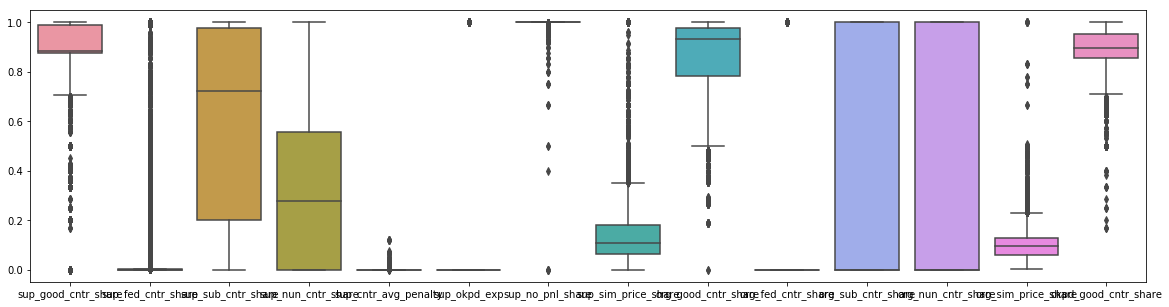

In [20]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
sb.boxplot(data=data[num_var01], ax=ax)

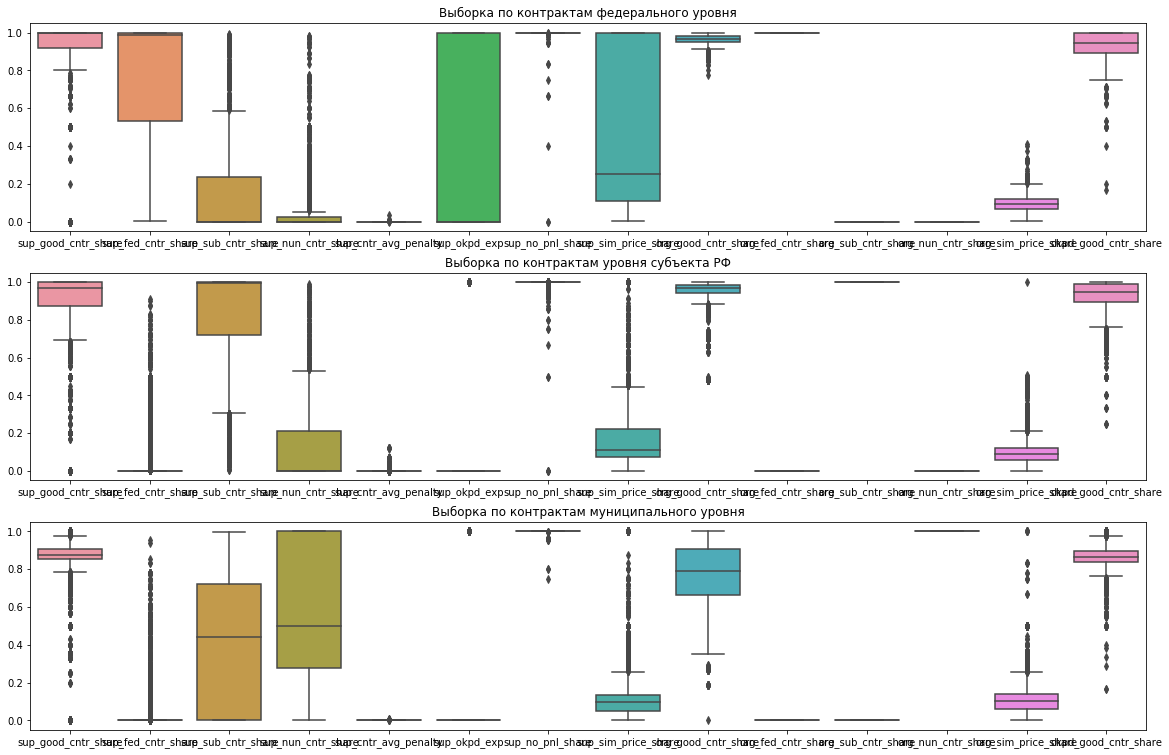

In [21]:
fig = plt.figure(figsize = (20,13))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.set_title('Выборка по контрактам федерального уровня')
ax2.set_title('Выборка по контрактам уровня субъекта РФ')
ax3.set_title('Выборка по контрактам муниципального уровня')

sb.boxplot(data=data.loc[data.cntr_lvl == 1][num_var01], ax=ax1)
sb.boxplot(data=data.loc[data.cntr_lvl == 2][num_var01], ax=ax2)
sb.boxplot(data=data.loc[data.cntr_lvl == 3][num_var01], ax=ax3)

In [22]:
num_var01_cntr = list(num_var01) + ['cntr_result']

In [23]:
data[num_var01_cntr].corr()

,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_cntr_avg_penalty,sup_okpd_exp,sup_no_pnl_share,sup_sim_price_share,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_nun_cntr_share,org_sim_price_share,okpd_good_cntr_share,cntr_result
sup_good_cntr_share,1.000000,0.013588,0.170719,-0.185177,0.021139,-0.265888,-0.008405,-0.315129,0.075958,0.013578,0.132012,-0.138312,-0.013873,0.220999,0.424109
sup_fed_cntr_share,0.013588,1.000000,-0.351248,-0.236908,-0.012344,0.143928,-0.022000,0.274860,0.193303,0.854757,-0.175363,-0.246102,-0.015677,0.169406,0.149886
sup_sub_cntr_share,0.170719,-0.351248,1.000000,-0.826329,0.052406,-0.084788,-0.013048,-0.094713,0.142731,-0.296711,0.694570,-0.546373,-0.226174,0.189943,0.146943
sup_nun_cntr_share,-0.185177,-0.236908,-0.826329,1.000000,-0.046947,0.001715,0.029921,-0.066811,-0.264452,-0.206230,-0.615373,0.715133,0.243887,-0.299215,-0.242544
sup_cntr_avg_penalty,0.021139,-0.012344,0.052406,-0.046947,1.000000,0.007550,-0.175385,-0.010601,0.031932,-0.010109,0.052096,-0.046963,-0.009432,0.051036,0.029703
sup_okpd_exp,-0.265888,0.143928,-0.084788,0.001715,0.007550,1.000000,-0.013323,0.569555,0.119124,0.131928,0.017767,-0.082738,-0.017887,0.126916,0.096142
sup_no_pnl_share,-0.008405,-0.022000,-0.013048,0.029921,-0.175385,-0.013323,1.000000,-0.033762,-0.017834,-0.021754,-0.019883,0.030530,0.018675,-0.032819,-0.017072
sup_sim_price_share,-0.315129,0.274860,-0.094713,-0.066811,-0.010601,0.569555,-0.033762,1.000000,0.251546,0.238666,0.070535,-0.187812,0.064320,0.233847,0.153673
org_good_cntr_share,0.075958,0.193303,0.142731,-0.264452,0.031932,0.119124,-0.017834,0.251546,1.000000,0.172619,0.511133,-0.594365,-0.032820,0.389954,0.534407
org_fed_cntr_share,0.013578,0.854757,-0.296711,-0.206230,-0.010109,0.131928,-0.021754,0.238666,0.172619,1.000000,-0.240906,-0.252007,-0.022748,0.145867,0.141121


In [24]:
def distplot01(variables, lvl=0, figsize=(15, 15)):
    fig = plt.figure(figsize=figsize)
    
    for i in range(1, len(variables) * 2 + 1):
        ax = fig.add_subplot(420 + i)

        if i == 1:
            ax.set_title('Хорошие контракты')
        elif i == 2:
            ax.set_title('Плохие контракты')
        
        if not lvl:
            sb.distplot(data.loc[data.cntr_result==i%2][variables[(i - 1) // 2]], ax=ax)
        elif lvl in (1, 2, 3):   
            sb.distplot(data.loc[(data.cntr_result==i%2) & (data.cntr_lvl == lvl)][variables[(i - 1) // 2]], ax=ax)
        else:
            raise TypeError('Некорректно задан уровен контракта. Возможные значения: 1, 2, 3.')

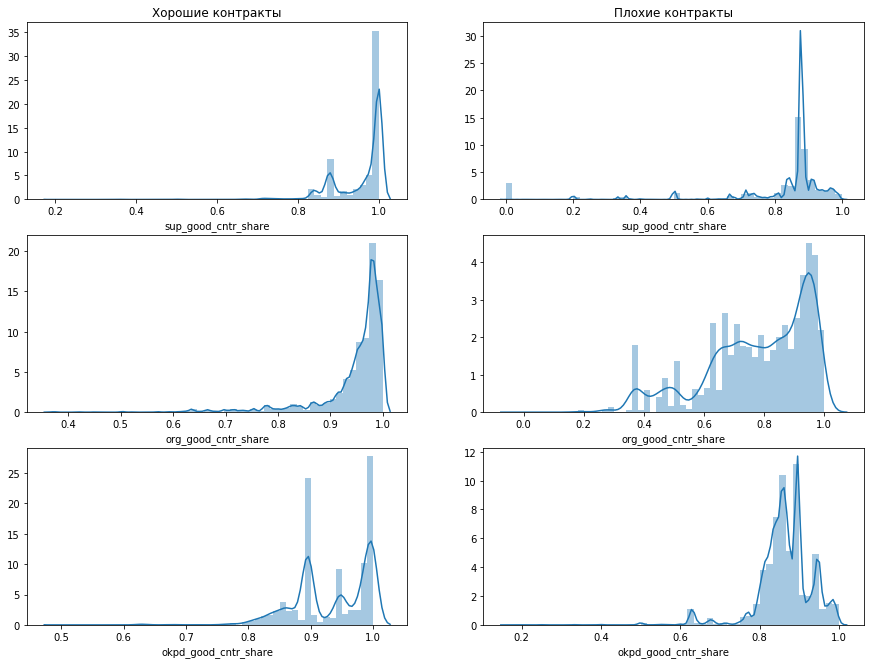

In [26]:
distplot01(['sup_good_cntr_share', 'org_good_cntr_share', 'okpd_good_cntr_share'])

### Анализ категориальных переменных

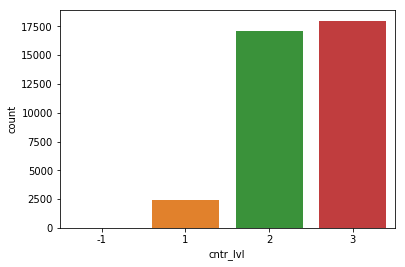

In [27]:
sb.countplot(x='cntr_lvl', data=data)

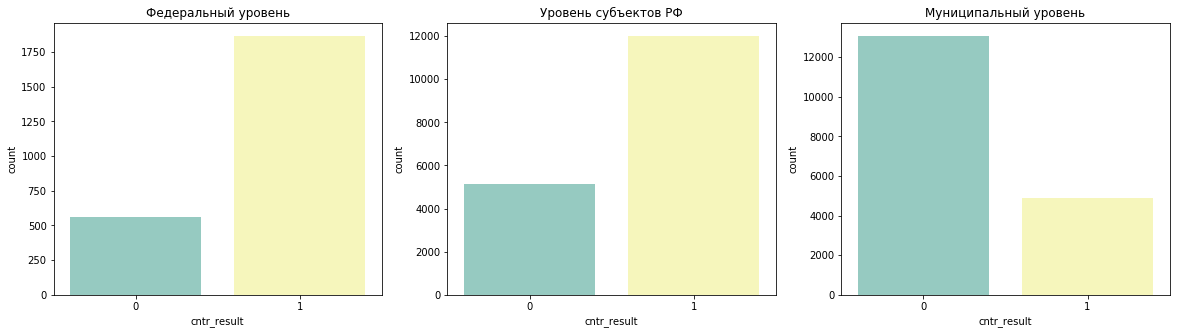

In [28]:
fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('Федеральный уровень')
ax2.set_title('Уровень субъектов РФ')
ax3.set_title('Муниципальный уровень')

sb.countplot(x='cntr_result', data=data.loc[data.cntr_lvl==1], palette='Set3', ax=ax1)
sb.countplot(x='cntr_result', data=data.loc[data.cntr_lvl==2], palette='Set3', ax=ax2)
sb.countplot(x='cntr_result', data=data.loc[data.cntr_lvl==3], palette='Set3', ax=ax3)

In [29]:
# Количество значений категориальных переменных
# Название переменной: кол-во значений на общей выборке, кол-во значений на выборке по контрактам федерального уровня
for cv in cat_var:
    print('{}: {}; {}, {}, {}'.format(
        cv, 
        len(set(data[cv])),
        len(set(data.loc[data.cntr_lvl==1][cv])),
        len(set(data.loc[data.cntr_lvl==2][cv])),
        len(set(data.loc[data.cntr_lvl==3][cv]))
    ))

sup_status: 7; 2, 7, 3
sup_type: 4; 4, 4, 4
org_form: 71; 35, 54, 45
org_type: 17; 15, 13, 12
okpd: 1820; 727, 1340, 825
cntr_lvl: 4; 1, 1, 1
purch_type: 7; 6, 7, 7


In [30]:
def cntr_distrib_over_cat_var(df, cat_var, fig_width=20, percent=True):
    """Распределение плохих и хороших контрактов по категориальной переменной cat_var"""
    
    total, bad, good = Counter(), Counter(), Counter()
    l, t, b, g = [], [], [], []

    for row in df[[cat_var, 'cntr_result']].itertuples():
        total[row[1]] += 1
        if row[2]:
            good[row[1]] += 1
        else:
            bad[row[1]] += 1

    for val in set(df[cat_var]):
        l.append(val)
        t.append(total.get(val))
        b.append(bad.get(val, 0))
        g.append(good.get(val, 0))

    df = pd.DataFrame({cat_var: l, 'bad': b, 'good': g, 'total': t}) 
    
    r = range(len(l))
    fig = plt.figure(figsize=(fig_width,5))
    ax = plt.subplot(111)
    plt.xticks(r, l)
    plt.xlabel(cat_var)
    
    if percent:
        df['bad_p'] = df['bad'] / df['total']
        df['good_p'] = df['good'] / df['total']

        ax.bar(r, df['bad_p'], color=BAD_CNTR_CLR, edgecolor='white', label='Плохие контракты')
        ax.bar(r, df['good_p'], bottom=df['bad_p'], color=GOOD_CNTR_CLR, edgecolor='white', label='Хорошие контракты')
        plt.ylabel("Доля")
        plt.title("Доля плохих и хороших контрактов в зависимости от {}".format(cat_var))
    else:
        ax.bar(r, df['bad'], color=BAD_CNTR_CLR, edgecolor='white', label='Плохие контракты')
        ax.bar(r, df['good'], bottom=df['bad'], color=GOOD_CNTR_CLR, edgecolor='white', label='Хорошие контракты')
        plt.ylabel("Количество")
        plt.title("Количество плохих и хороших контрактов в зависимости от {}".format(cat_var))
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [31]:
# Создание трех новых переменных: год, месяц, квартал подписания контракта
data['year'] = data['sign_date'].apply(lambda a: pd.Series(int(str(a)[:4])))
data['month'] = data['sign_date'].apply(lambda a: pd.Series(int(str(a)[4:6])))
data['quarter'] = data['month'].apply(lambda a: pd.Series((a - 1) // 3 + 1))

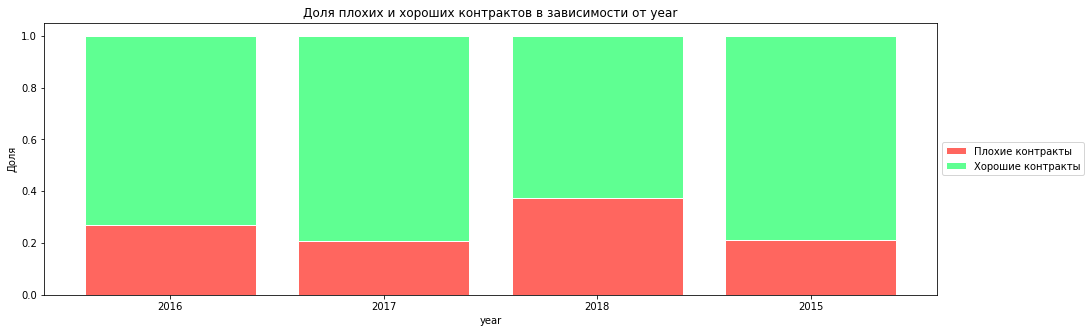

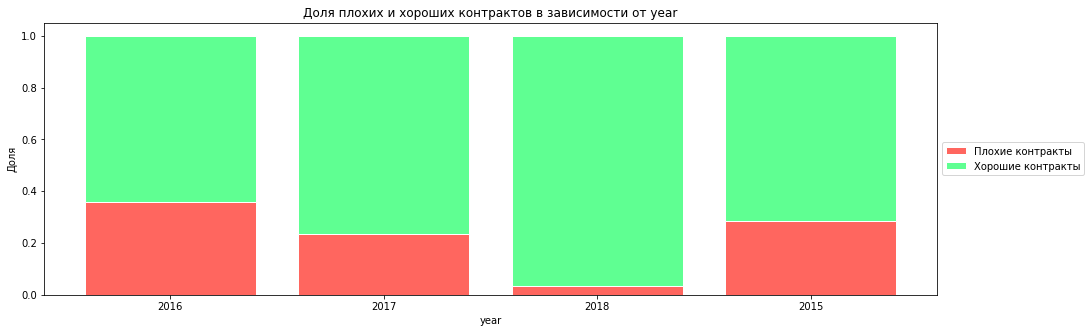

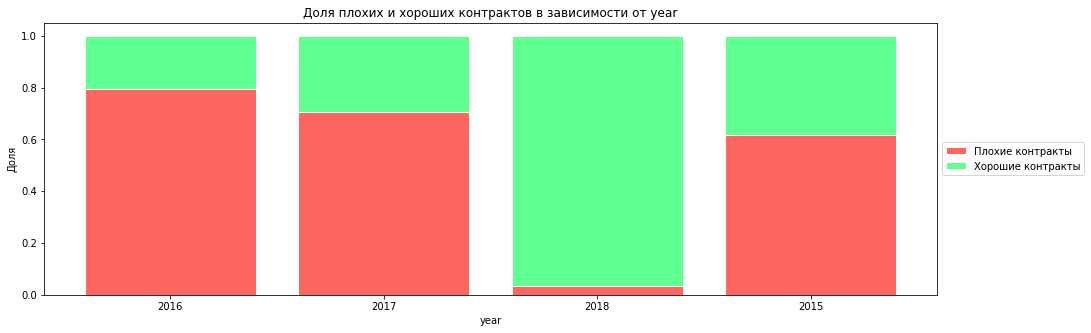

In [32]:
# Распределение хороших и плохих контрактов по категориальной переменной year (год начала контракта)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'year')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'year')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'year')

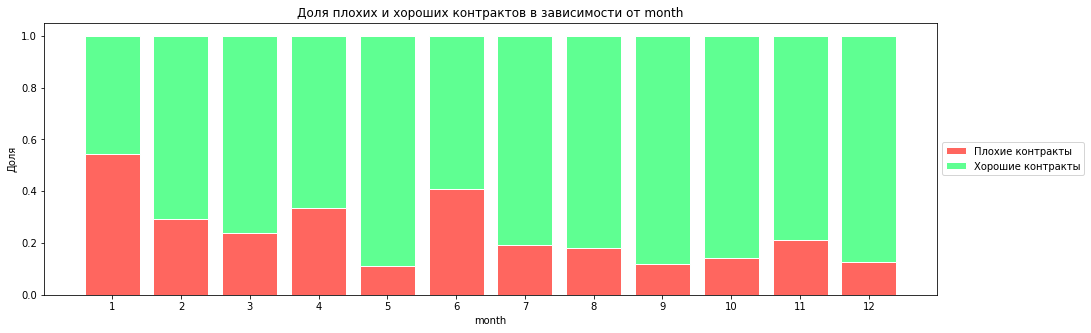

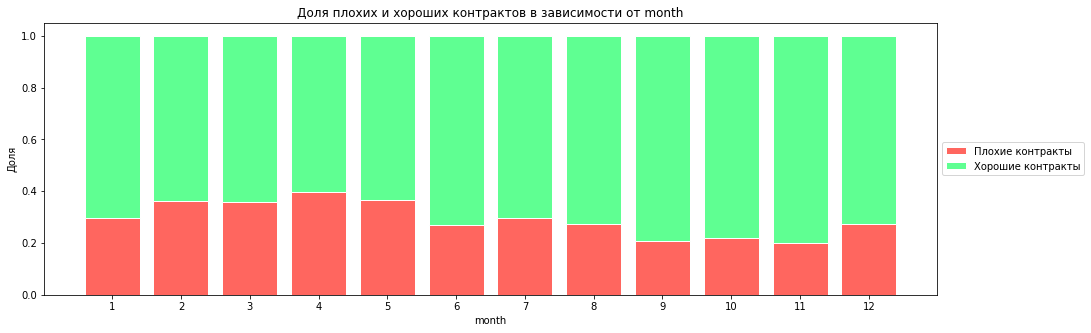

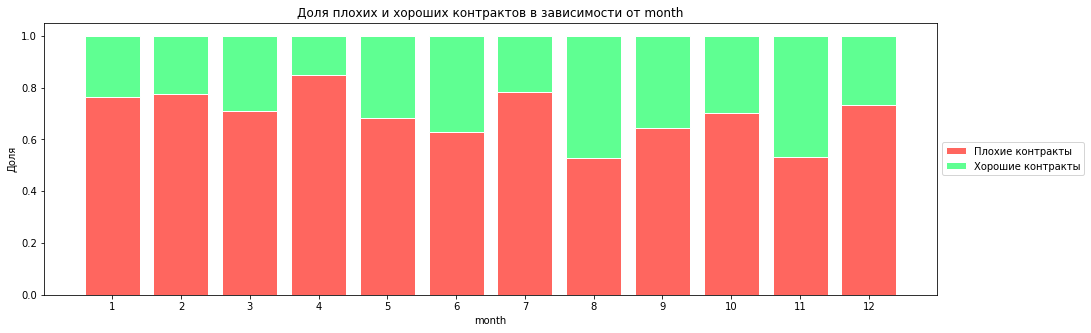

In [33]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'month')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'month')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'month')

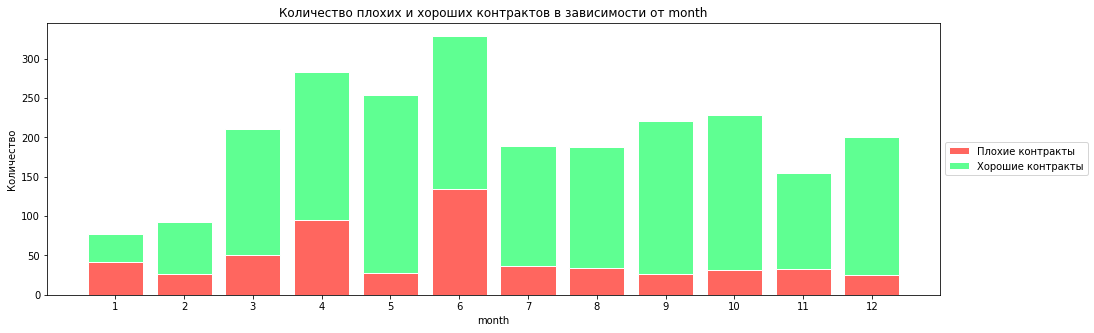

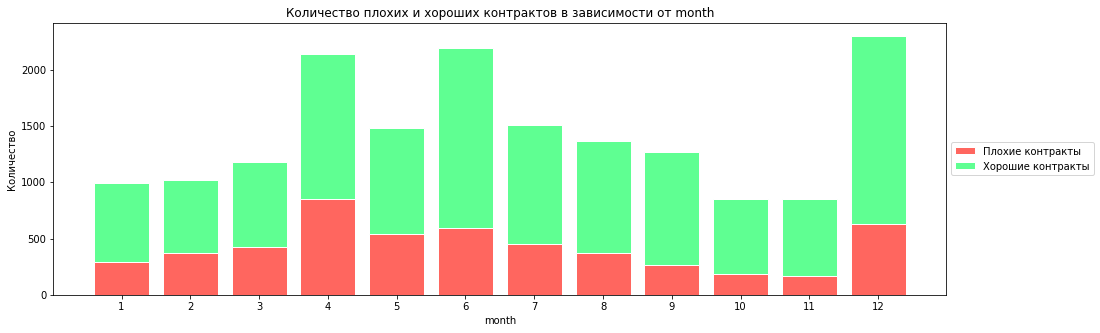

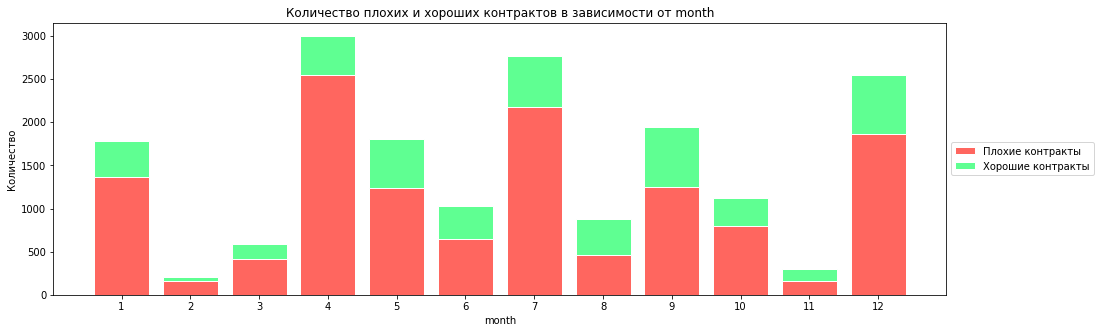

In [34]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'month', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'month', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'month', percent=False)

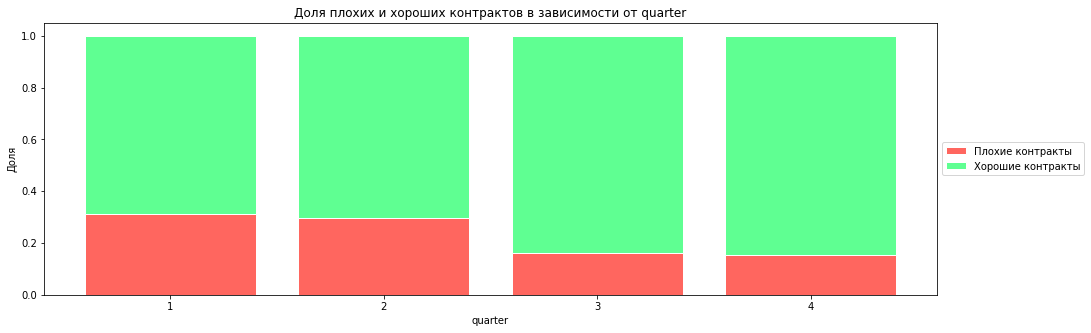

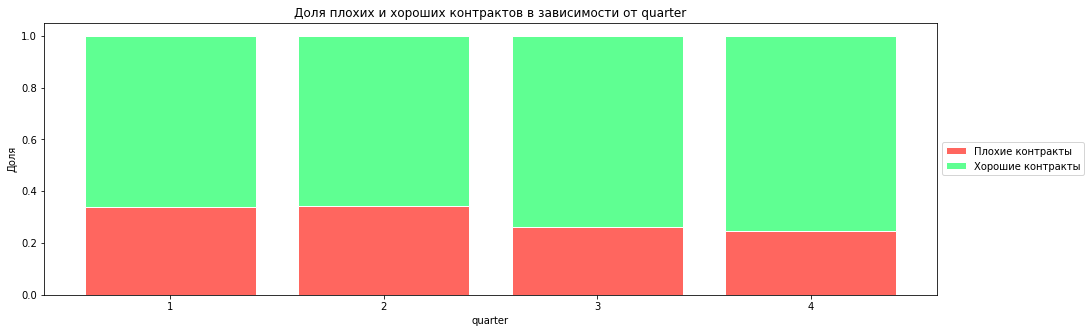

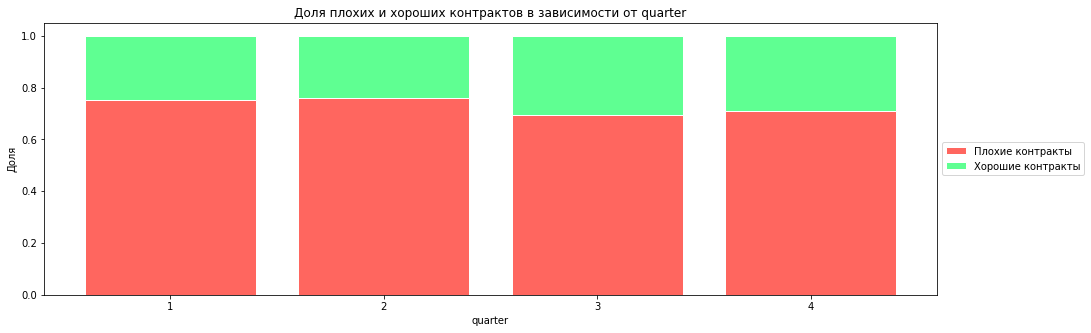

In [35]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'quarter', percent=True)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'quarter', percent=True)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'quarter', percent=True)

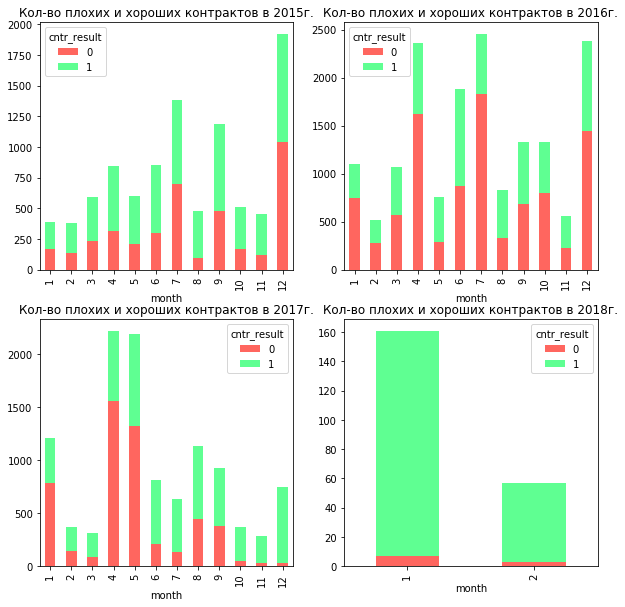

In [36]:
# Количество контрактов по месяцам для каждого года по ОВ
fig = plt.figure(figsize=(10,10))
for idx, year in enumerate((2015, 2016, 2017, 2018)):
    ax = fig.add_subplot(220 + idx + 1)
    data[data['year']==year].groupby(['month', 'cntr_result'])['cntr_result'].count().unstack().plot(
        kind='bar', 
        stacked=True,
        title='Кол-во плохих и хороших контрактов в {}г.'.format(year), 
        color=[BAD_CNTR_CLR, GOOD_CNTR_CLR],
        ax=ax
    )

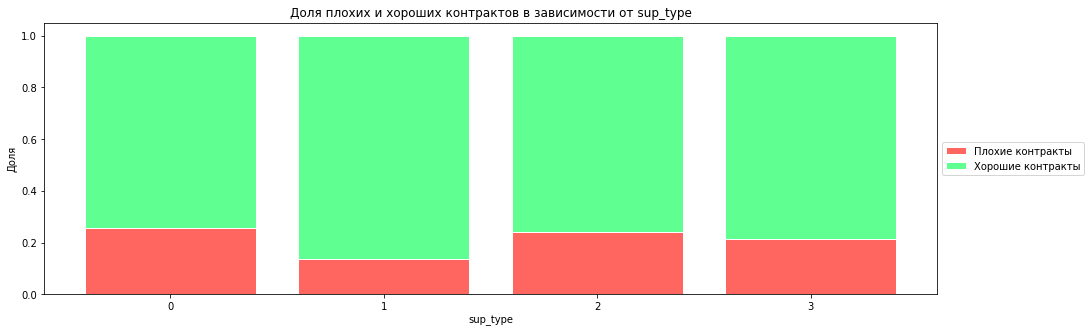

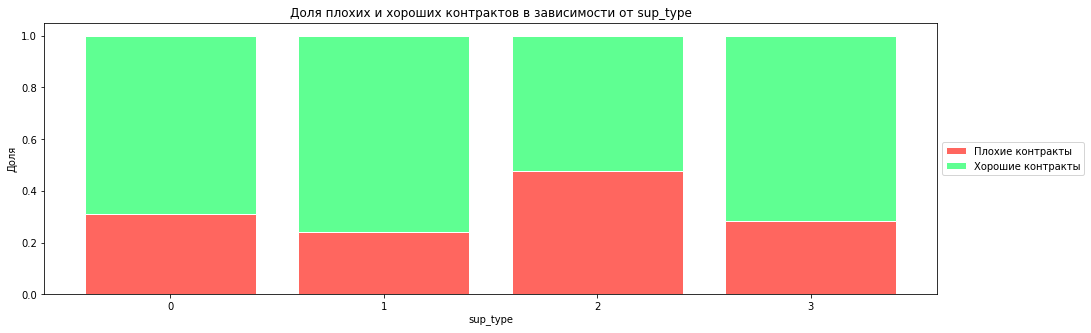

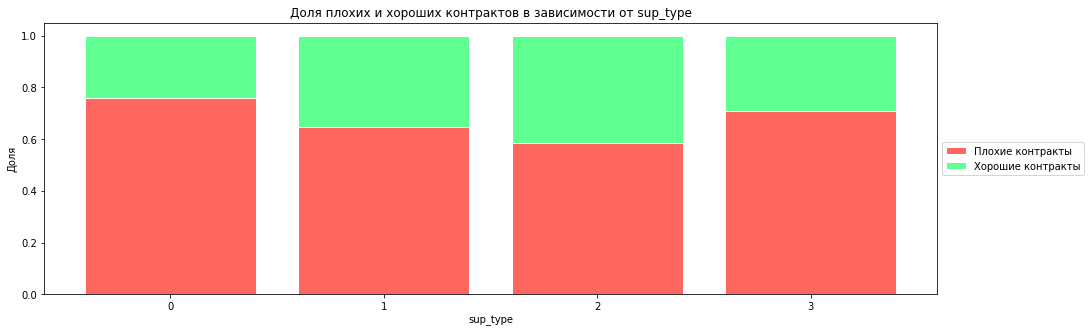

In [37]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'sup_type', percent=True)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'sup_type', percent=True)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'sup_type', percent=True)

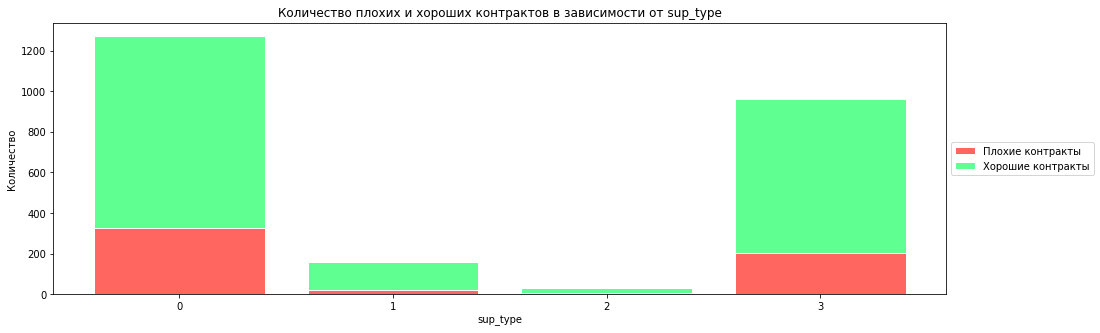

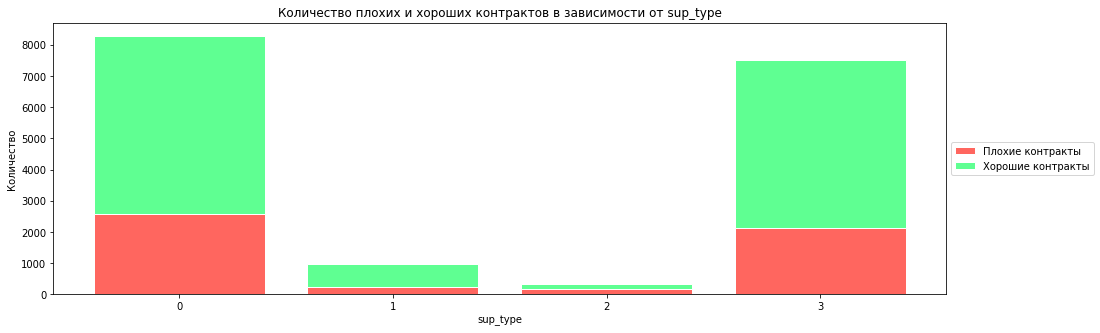

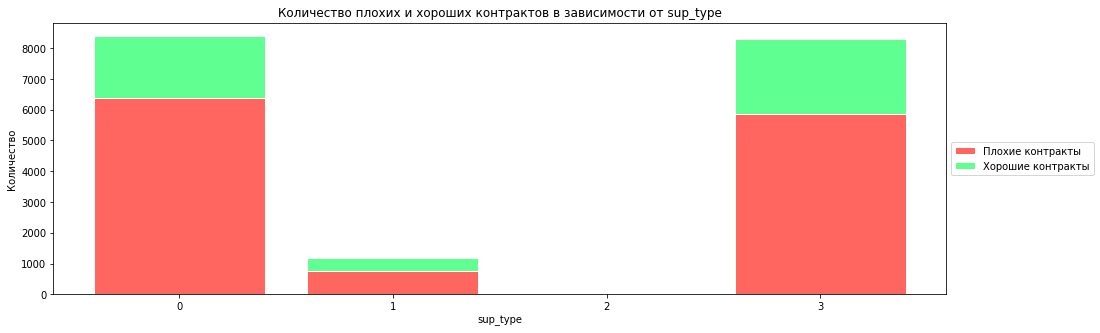

In [38]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'sup_type', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'sup_type', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'sup_type', percent=False)

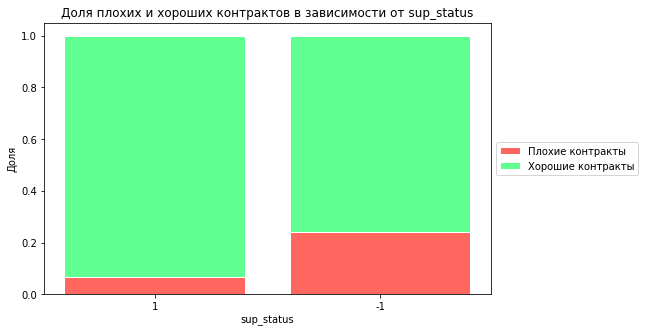

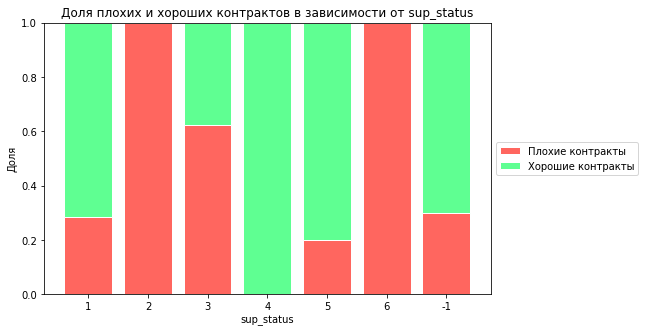

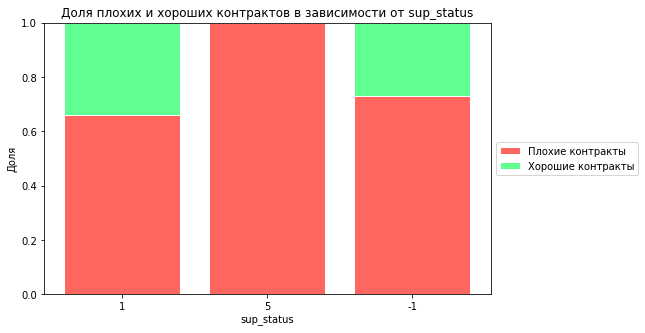

In [39]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'sup_status', fig_width=10)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'sup_status', fig_width=10)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'sup_status', fig_width=10)

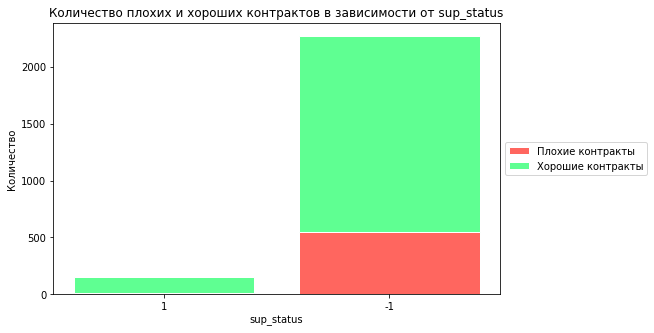

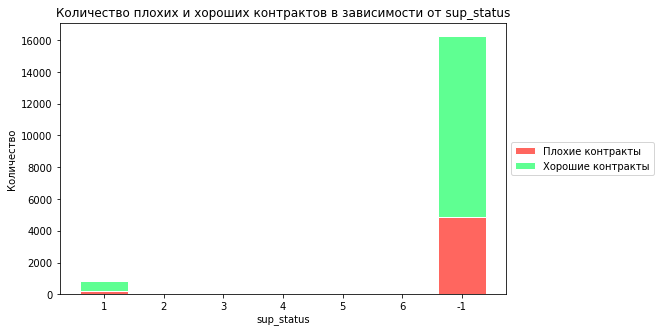

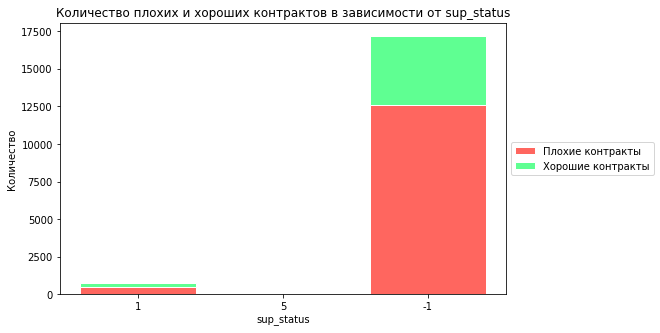

In [40]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'sup_status', percent=False, fig_width=10)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'sup_status', percent=False, fig_width=10)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'sup_status', percent=False, fig_width=10)

Переменная sup_status не может быть использована, так как очень много значений пропущено

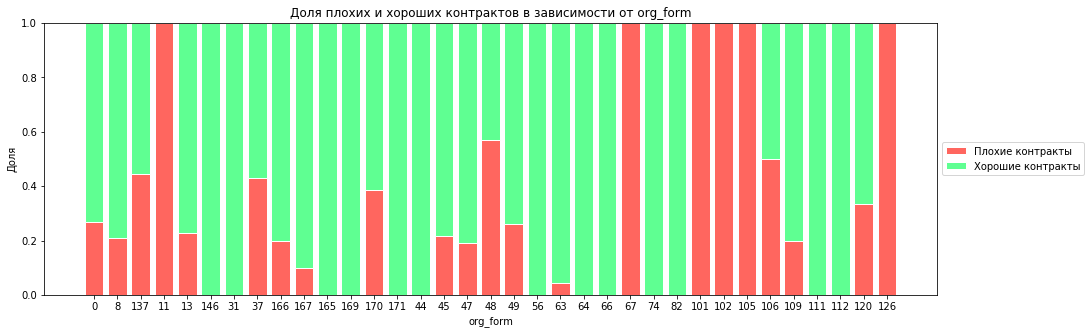

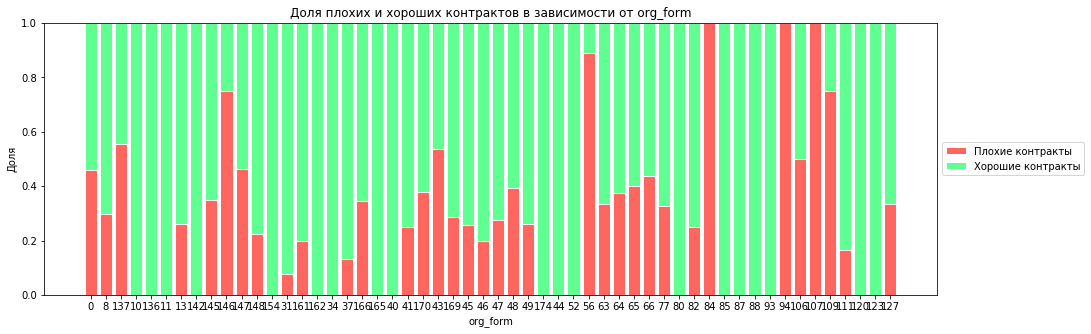

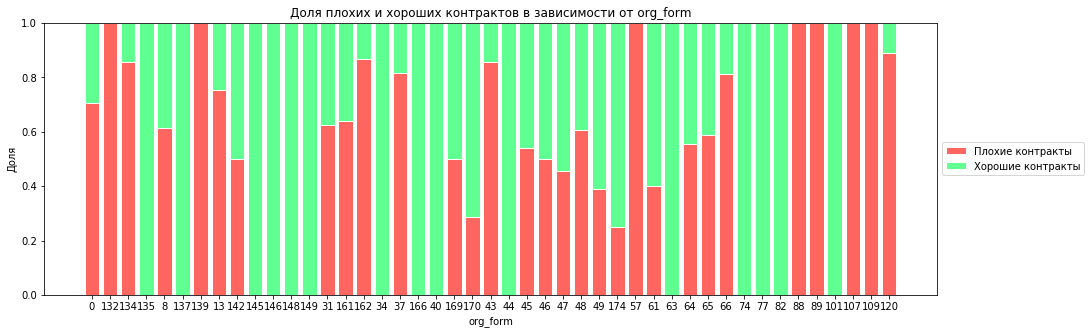

In [41]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'org_form')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'org_form')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'org_form')

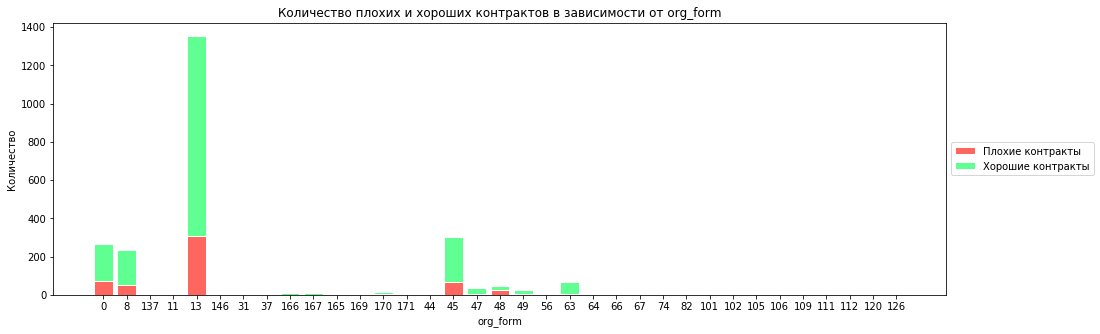

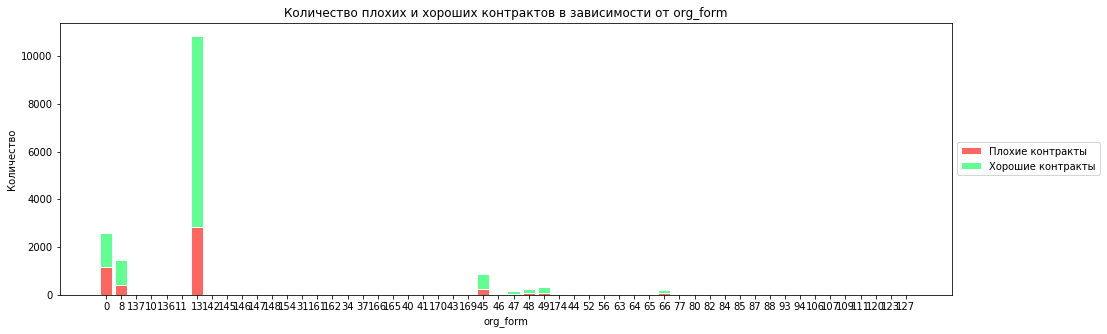

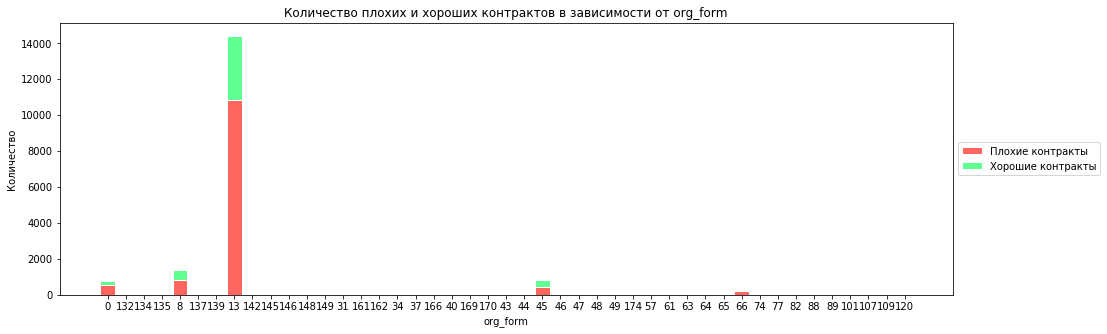

In [42]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'org_form', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'org_form', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'org_form', percent=False)

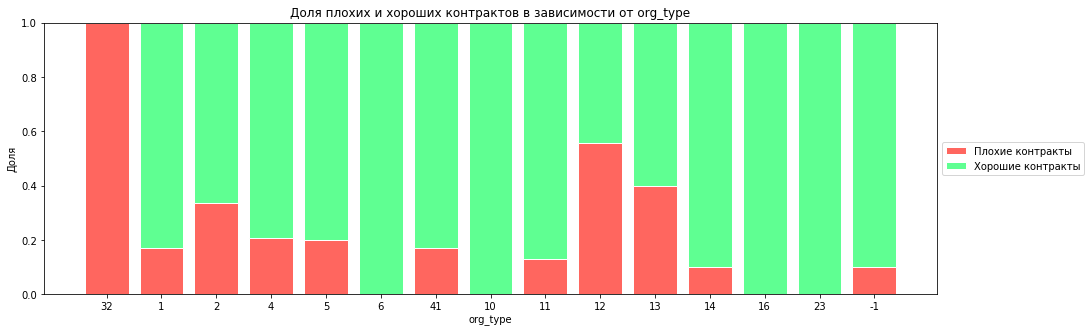

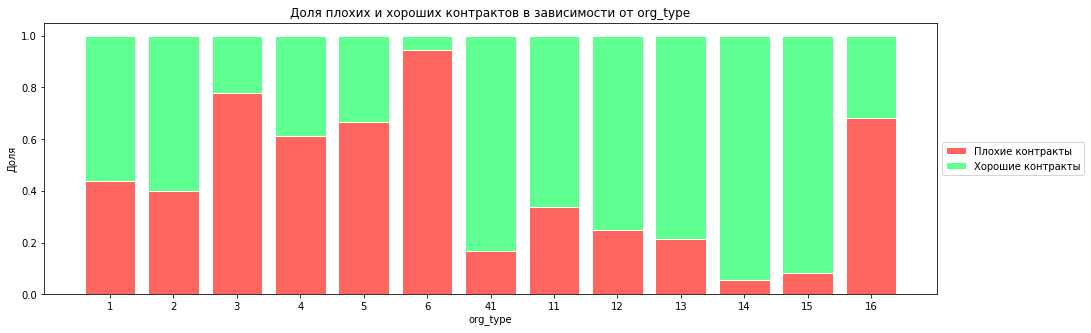

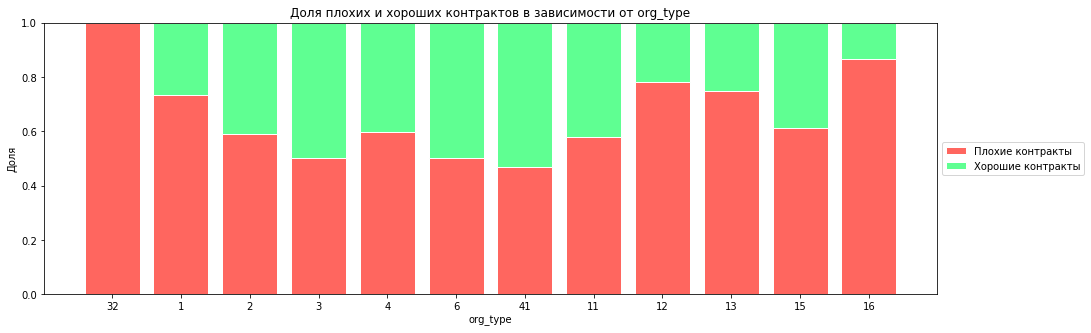

In [43]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'org_type')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'org_type')
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'org_type')

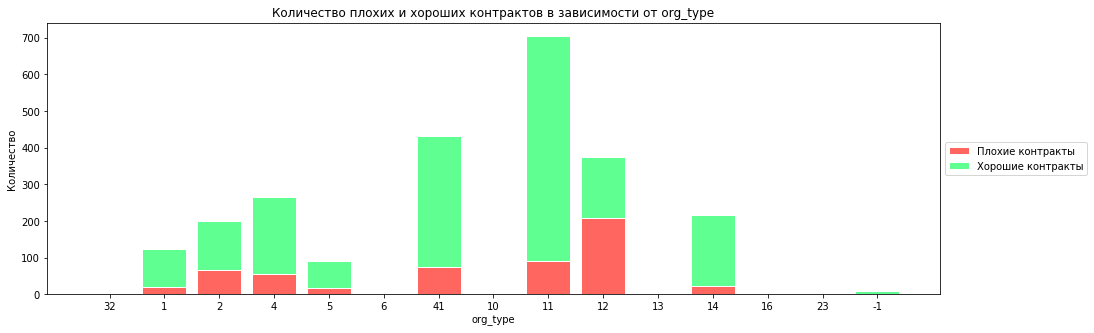

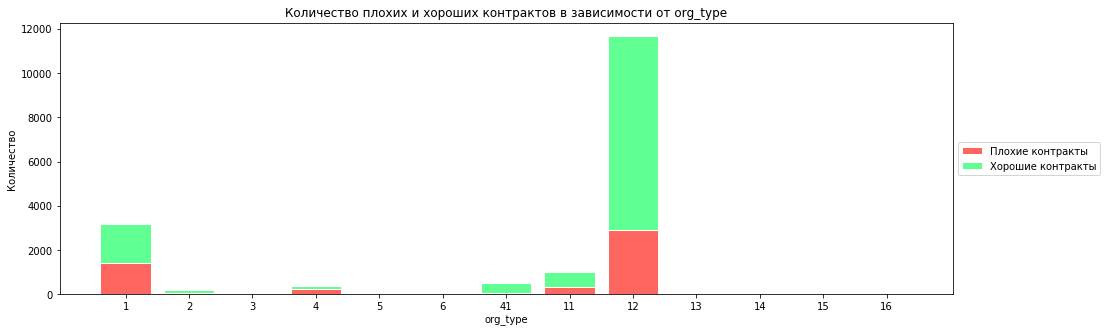

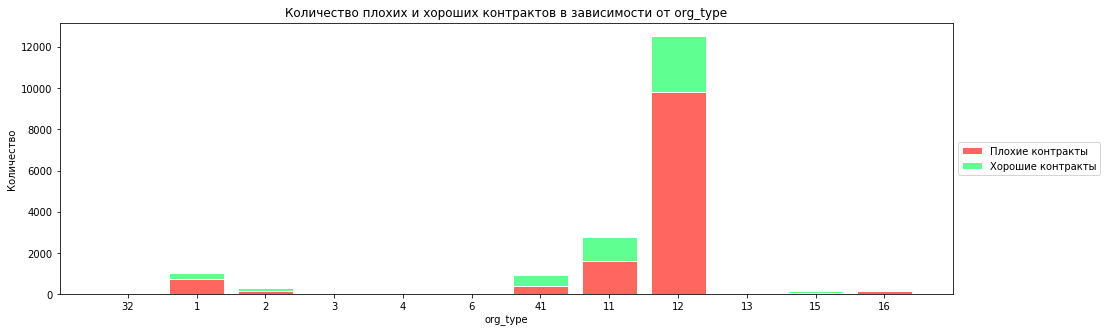

In [44]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'org_type', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'org_type', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'org_type', percent=False)

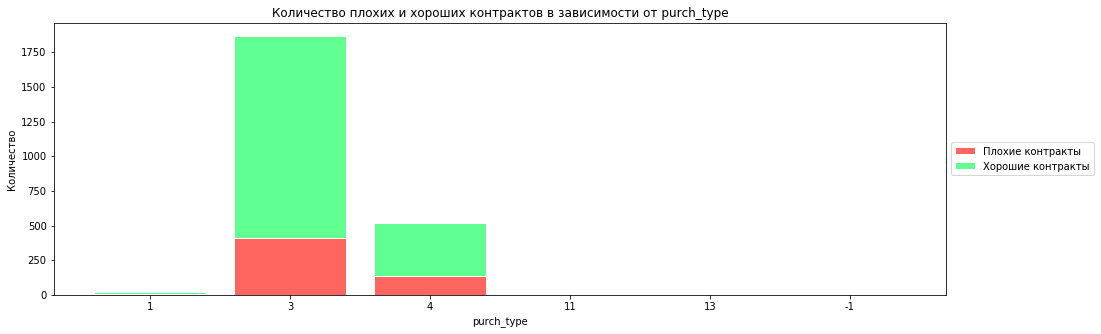

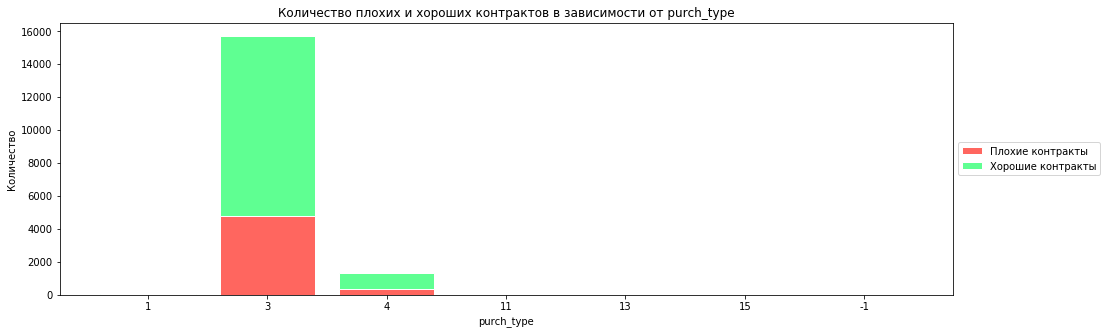

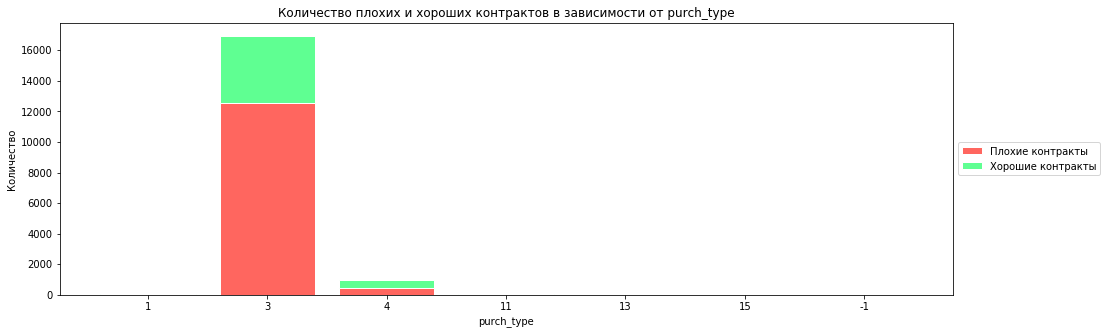

In [45]:
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==1], 'purch_type', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==2], 'purch_type', percent=False)
cntr_distrib_over_cat_var(data.loc[data.cntr_lvl==3], 'purch_type', percent=False)

In [46]:
# Создание новой переменной, отвечающей за первые два символа ОКПД2
data['okpd_class'] = data['okpd'].apply(lambda a: pd.Series(a[:2]))

In [47]:
okpd_mean = data[['okpd_good_cntr_share', 'okpd_class']].groupby('okpd_class')['okpd_good_cntr_share'].mean()
data = data.join(okpd_mean, on='okpd_class', rsuffix='_class')

### Анализ категориальных бинарных переменных

In [48]:
cat_bin_var_cntr = list(cat_bin_var) + ['cntr_result']
data[cat_bin_var_cntr].corr()

,price_higher_pmp,price_too_low,cntr_result
price_higher_pmp,1.000000,-0.031553,0.041567
price_too_low,-0.031553,1.000000,0.107490
cntr_result,0.041567,0.107490,1.000000


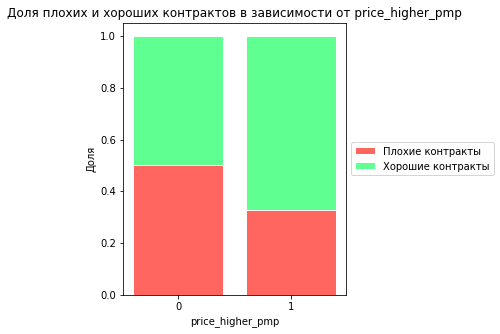

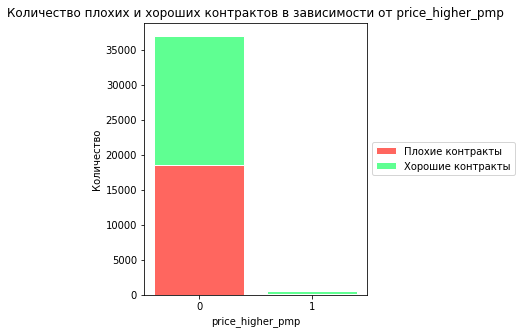

In [49]:
cntr_distrib_over_cat_var(data, 'price_higher_pmp', fig_width=5)
cntr_distrib_over_cat_var(data, 'price_higher_pmp', fig_width=5, percent=False)

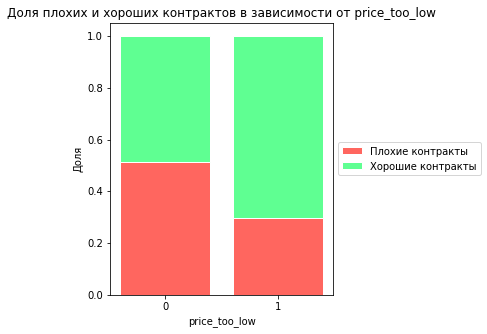

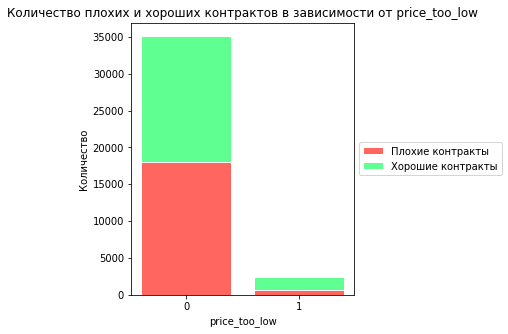

In [50]:
cntr_distrib_over_cat_var(data, 'price_too_low', fig_width=5)
cntr_distrib_over_cat_var(data, 'price_too_low', fig_width=5, percent=False)

**Выводы.** 
1. Редко наблюдаются случаи, когда цена выше МНЦК (price_higher_pmp). 
2. Когда этот критерий срабатывает, доля хороших контрактов не уменьшается, а наоборот увеличивается. 
3. Аналогичные размышления верны для переменной price_too_low и данных как из ОВ, так и из ВФК.

### Выбор признаков

**Обзор**. В данной части будет добавлено несколько дополнительных признаков, которые мне показались интересными. А затем будет произведена оценена важность всех признаков на ОВ и ВФК отличными от линейной корреляции методами (Хи-квардрат, ANOVA). Результаты в самом конце.

In [51]:
cntr_start = data['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
cntr_end = data['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
data['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))

data.drop(data[data.cntr_length == 0].index, inplace=True)

In [52]:
data.loc[data.sup_type == 0, 'sup_type'] = 3
data.loc[(data.org_form == 45) | (data.org_form == 0), 'org_form'] = 13
data.loc[(data.org_type == 1) | (data.org_type == -1), 'org_type'] = 12
data.loc[data.cntr_lvl == -1, 'cntr_lvl'] = 3
data.loc[data.purch_type == -1, 'purch_type'] = 3

In [53]:
data['okpd_good_cntr_share_class'] = data['okpd_good_cntr_share_class'].round(3)

In [54]:
data['price_pmp_diff'] = data['pmp'] - data['price']
data['avg_cntr_price_diff'] = data['sup_cntr_avg_price'] - data['price']

In [55]:
# Формируем признаки
X = data.drop([
    'cntrID', 'cntr_result', 'okpd', 'sign_date', 'exec_date', 
    'sup_status', 'sup_status', 'price', 'pmp', 'okpd_good_cntr_share',
    'sup_no_pnl_share', 'sup_1s_sev', 'sup_1s_org_sev', 'org_1s_sev', 'org_1s_sup_sev', 'year', 'month',
    'price_higher_pmp', 'price_too_low'], axis=1)

In [56]:
columns = X.columns

y = data.cntr_result.values

In [57]:
def rate_feature_importance(X_values, y_values, func_list, columns, alias=''):
    """Функция для тестирования важности признаков"""
    
    result_dict = {}
    result_list = []
    
    for func in func_list:
        test = SelectKBest(score_func=func)
        fit = test.fit(X_values, y_values)
        res = sorted(
            dict(zip(columns, [e for e in list(fit.scores_)])).items(),
            key=lambda a: a[1],
            reverse=True
        )
        
        func_name = str(func).split()[1]
        dict_key = '{}_{}'.format(alias, func_name) if alias else func_name
        
        result_dict[dict_key] = [i[0] for i in res]
        result_list.append(res)
    
    return pd.DataFrame(result_dict), result_list

In [58]:
res_data, _ = rate_feature_importance(X.values, y, [f_classif], columns)

In [59]:
res_data

,f_classif
0,org_good_cntr_share
1,okpd_good_cntr_share_class
2,org_nun_cntr_share
3,sup_good_cntr_share
4,cntr_lvl
5,org_sub_cntr_share
6,sup_cntr_num
7,org_cntr_num
8,cntr_num_together
9,sup_nun_cntr_share
